# Purpose
"Tech"
- Detecting and predicting Atrial Fibrillation(AF) w/ time course data of ECG and a series of its perosonal history
- AF: Cardio-vascular disease, irregular heartbeat 
- leading to Stroke, Heart failure and other heart-related disease

"Biz.Dev"
- RWD+ad-hoc RWD: Rough, ad-hoc: Fine, contributing to the pharma R&D, sale and QC in pre/post market drug delivery.  
- 12 leads -> 1leads similar to wearable watch like Apple watch 
- Pre-Projectized, estimate to the the difficulty to build the model 

# Data and model
- ECG time-course, 8 independent leads
- ResNet, refered in JAMA 2019 from Mayo Clinic

# Demo
- Try to construct the identical model
- temporal label data from the M.D (not diagnosis)

# To Do
- ✔grasping ECG features and understand the points to see (w/Dr)
- ☆replacing labels (in parallel) 
- set the strategy of constructing model 


# Comment
- Code review with team member

In [1]:
# モジュールのインポート
import os,sys
import csv
import pprint
import shutil
import datetime, time
import openpyxl
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.model_selection import train_test_split

import keras
from keras.models import *
from keras.layers import *
from keras.utils import *
from keras.optimizers import *

from IPython.core.debugger import Pdb 

Using TensorFlow backend.
C:\Users\yusuke-asada\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\yusuke-asada\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\yusuke-asada\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\yusuke-asada\Anaconda3\lib\site-packages\tensorflo

In [2]:
#- ECGのCSVデータフォルダ
csvfile =  '\\Users\yusuke-asada\Documents\data\ecg\csv\*' #N=8000　本番用
# csvfile =  '\\Users\yusuke-asada\Documents\data\ecg\csv2\*' #N=1000　デバック予備
# csvfile =  '\\Users\yusuke-asada\Documents\data\ecg\csv_temp\*' #N=6 デバック用
files = glob.glob(csvfile) 

#- ECGデータのラベルデータ
# labels =  '\\Users\yusuke-asada\Documents\data\ecg\label\label3.csv' #ファイルを開くフォルダ
labels =  '\\Users\yusuke-asada\Documents\data\ecg\label\label3_add.csv' #ファイルを開くフォルダ

In [3]:
# ディレクトリ内のファイルの数を数える
path, dirs, files_temp = next(os.walk(csvfile[:-2]))
file_count = len(files_temp)
ndata = file_count # ndata = 6, 1000, 8000 いずれか

# XMLファイルを読み込む
out = np.zeros((ndata, 5000, 8)) # zero
out[:,:] = np.nan
pp = 0

# --データを採用する条件--
# 独立８誘導
# データが5000点のもの（10秒分）
# デバイスからラベルが出力されている, label<9

nlead = 8
nlen = 5000
label_thr = 9

for ii, file in enumerate(files):
    # カウンター（読み込みに時間がかかる）
    mod = ii%50
    if mod == 0:
        print(ii)
    
    # XMLファイルの読み込み
    filename = file[-30:-4]
    xmlfilename = filename+".XML" #'M00300R0003_20200114150848.XML'
    f = open(file, 'r')
    reader = csv.reader(f)
    
    # XMLファイル ヘッダーデータ
    header = next(reader) # ['Sampling', '0.002', 'sec', 'Resolution', '4.88', 'uV']
    header_2 = next(reader) # ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'] 
    sample_rate = float(header[1]) # サンプリングレート
    resolution = float(header[4]) # 分解能
    
    # 独立８誘導であれば、フラグを立てる(8誘導と3誘導データがある)
    if len(header_2) == nlead:
        flag = 1 # 8leads
    else:
        flag = 0 # 3leads
    
    # 独立８誘導であれば、モデル用のデータとして採用する
    if flag == 1:
        csv_input = pd.read_csv(filepath_or_buffer = file, encoding="ms932", sep=",")
        data = []
        for c in csv.reader(f):
                data.append(c)

        # 数値に変換
        fdata = []
        for jj in np.arange(len(data)):
            temp = [float(s) for s in data[jj]]
            if jj == 0:
                fdata = temp
            else:
                # 行に追加
                fdata = np.vstack((fdata, temp))

        # ベースライン補正
        # 描画ではこの処理は必要だが、モデル構築で必要がは不明
        fdata_copy = fdata.copy()
        fdata_base = np.mean(fdata_copy[0:5], axis = 0) # 両端5点を使う
        fdata_norm = (fdata - fdata_base)*resolution/1000
        
        # データが5000点のものだけを採用
        if fdata_norm.shape[0] == nlen:
            for jj in range(fdata_norm.shape[0]):
                for kk in range(fdata_norm.shape[1]):
                    out[pp, jj, kk] = fdata_norm[jj][kk]

            # CSVラベルデータ
            dic = pd.read_csv(filepath_or_buffer = labels, encoding="ms932", sep=",")
            
            # XMLファイルと一致したラベルを抽出する
            dic_pick = dic[dic['xmlname'] == xmlfilename]
            xml = dic_pick['xmlname']
            num = dic_pick["label_num"]
            
            # 表にコラムを追加する
            dic_pick["flag"] = flag
            dic_pick["row"] = fdata_norm.shape[0]
            dic_pick["column"] = fdata_norm.shape[1]
            
            # ラベルデータがあるものだけを採用する
            # ※"9"はラベルがないものなので、9より小さいラベルのみ採用する
            if int(num) < label_thr:
                for jj in range(fdata_norm.shape[0]):
                    for kk in range(fdata_norm.shape[1]):
                        out[pp, jj, kk] = fdata_norm[jj][kk]

                # 表データの追加
                if ii == 0:
                    dic2 = dic_pick.copy()
                if ii > 0:
                    dic2 = pd.concat([dic2, dic_pick]) 
                # indexの更新
                pp = pp + 1

# 以上、Pandasを使いこなせていないのでforでがんばった
# DataFrameでキレイに直せるようになりたい
out = out[:pp]
print('End of load')

0


C:\Users\yusuke-asada\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\yusuke-asada\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\yusuke-asada\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
End of load


In [5]:
# 条件に見合うものだけを抽出する
data_dic = dic2.query('flag == 1 & row == 5000 & label_num < 9')
index = data_dic["index"].astype(int)

# 両端をpadding（長さはなんとなく）
left_pad = 60 #10+25+25
right_pad = 60 # 10+25+25

features_pad = np.zeros((index.shape[0],(nlen+left_pad+right_pad)*nlead)) # zero
for ii in range(index.shape[0]):
    temp = np.pad(out[ii][0:nlen], [(left_pad,right_pad), (0,0)], 'edge')
    temp = temp.T
    features_pad[ii] = temp.reshape([1, (nlen+left_pad+right_pad)*nlead])
    
print("features_pad.shape"); print(features_pad.shape);

# ラベルデータ:one hot shot
data_label = data_dic["label_num_dpc"].astype(int)
targets = to_categorical(data_label)
bls = np.sum(targets, axis = 0)
print("data-balance, pre down sample"); print(bls)

# ダウンサンプリング
# ※暫定で前からnon-AFデータを前から順番に選んだ。
# ※バイアスがある可能性があるので要修正
nsample = int(np.min(bls))
target_len = targets.shape[0]
target_index = np.zeros(target_len)
target_index[:] = np.nan

target_index_0 = target_index.copy()
target_index_1 = target_index.copy()

fp = pd.DataFrame(features_pad.T)
tg = pd.DataFrame(targets.T)

jj = 0
kk = 0
for ii in range(target_len):
    temp = int(targets[ii,0])
    if temp == 1:
        target_index_0[jj] = ii
        jj = jj + 1
    else:
        target_index_1[kk] = ii
        kk = kk + 1

target_index_0 = target_index_0[~np.isnan(target_index_0)]
target_index_1 = target_index_1[~np.isnan(target_index_1)]    

# ここが要修正ポイント
fp0 = fp[target_index_0[0:nsample]]
fp1 = fp[target_index_1]
tg0 = tg[target_index_0[0:nsample]]
tg1 = tg[target_index_1]

fps = pd.concat([fp0, fp1], axis = 1)
tgs = pd.concat([tg0, tg1], axis = 1)

features_pad = fps.values.T
targets = tgs.values.T

bls_down = np.sum(targets, axis = 0)
print("data-balance, post down sample"); print(bls_down)

features_pad.shape
(6610, 40960)
data-balance, pre down sample
[6114.  496.]
data-balance, post down sample
[496. 496.]


In [6]:
# data preparation
# split
x_train, x_test, y_train, y_test = train_test_split(features_pad, targets, train_size=0.7)

# reshape
x_train_re = x_train.reshape([x_train.shape[0], nlead, (nlen + left_pad + right_pad)])
x_test_re = x_test.reshape([x_test.shape[0],nlead, (nlen + left_pad + right_pad)])
x_train_input = x_train.reshape(x_train.shape[0], nlead, (nlen + left_pad + right_pad),1)
x_test_input = x_test.reshape(x_test.shape[0],nlead, (nlen + left_pad + right_pad),1)

C:\Users\yusuke-asada\Anaconda3\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\Users\yusuke-asada\Anaconda3\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\Users\yusuke-asada\Anaconda3\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\Users\yusuke-asada\Anaconda3\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\Users\yusuke-asada\Anaconda3\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise compar

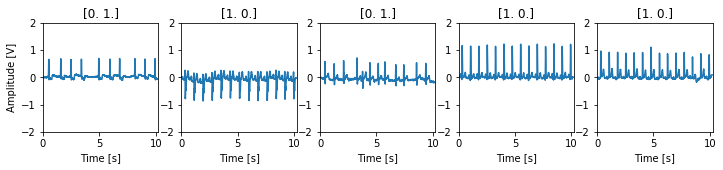

In [7]:
# データの確認：描画
# タイムスタンプ
timestamp = np.arange(x_train_re.shape[2]) * sample_rate

plt.figure(figsize=(12,2))
for i in range(5):
    y = x_train_re[i][1][:] # x_train_re[index][誘導番号][:], x_train = (525, 8, 699)
    plt.subplot(1,5,i+1)
    plt.title(y_train[i]) # [non-AF, AF]
    plt.grid(False)
    plt.plot(timestamp, y)
    plt.xlim(timestamp[0], timestamp[-1])
    plt.ylim(-2, 2)
    plt.xlabel("Time [s]")
    if i == 0:
        plt.ylabel("Amplitude [V]")
plt.show()

In [8]:
# モデル
inputs = Input(shape = (x_train_re.shape[1], x_train_re.shape[2],1) )

# 1
x_10 = BatchNormalization()(inputs)
x_11 = Activation('relu')(x_10)
x_12 = Conv2D(filters = 12, kernel_size = (7,1), strides = 1, padding='same')(x_11)

x_13 = BatchNormalization()(x_12)
x_14 = Activation('relu')(x_13)
x_15 = Conv2D(filters = 12, kernel_size = (7,1), strides = 2, padding='same')(x_14)

s_11 = Conv2D(filters = 12, kernel_size = (1,1), strides = 1, padding='same')(inputs)
s_12 = MaxPooling2D(pool_size= 2, padding='same')(s_11)

x_16 = concatenate([x_15, s_12], axis = 1)
x_out_1 = Dense(16)(x_16)

# 2
x_20 = BatchNormalization()(x_out_1)
x_21 = Activation('relu')(x_20)
x_22 = Conv2D(filters = 12, kernel_size = (7,1), strides = 1, padding='same')(x_21)

x_23 = BatchNormalization()(x_22)
x_24 = Activation('relu')(x_23)
x_25 = Conv2D(filters = 12, kernel_size = (7,1), strides = 2, padding='same')(x_24)

s_21 = Conv2D(filters = 12, kernel_size = (1,1), strides = 1, padding='same')(x_out_1)
s_22 = MaxPooling2D(pool_size= (2, 2), padding='same')(s_21)

x_26 = concatenate([x_25, s_22], axis = 1)
x_out_2 = Dense(16)(x_26)

# 3
x_30 = BatchNormalization()(x_out_2)
x_31 = Activation('relu')(x_30)
x_32 = Conv2D(filters = 12, kernel_size = (7,1), strides = 1, padding='same')(x_31)

x_33 = BatchNormalization()(x_32)
x_34 = Activation('relu')(x_33)
x_35 = Conv2D(filters = 12, kernel_size = (7,1), strides = 2, padding='same')(x_34)

s_31 = Conv2D(filters = 12, kernel_size = (1,1), strides = 1, padding='same')(x_out_2)
s_32 = MaxPooling2D(pool_size= (2, 2), padding='same')(s_31)

x_36 = concatenate([x_35, s_32], axis = 1)
x_out_3 = Dense(16)(x_36)

#drop 1
x_drop_1 = Dropout(0.2)(x_out_3)

# 4
x_40 = BatchNormalization()(x_drop_1)
x_41 = Activation('relu')(x_40)
x_42 = Conv2D(filters = 12, kernel_size = (5,1), strides = 1, padding='same')(x_41)

x_43 = BatchNormalization()(x_42)
x_44 = Activation('relu')(x_43)
x_45 = Conv2D(filters = 12, kernel_size = (5,1), strides = 2, padding='same')(x_44)

s_41 = Conv2D(filters = 12, kernel_size = (1,1), strides = 1, padding='same')(x_drop_1)
s_42 = MaxPooling2D(pool_size= (2, 2), padding='same')(s_41)

x_46 = concatenate([x_45, s_42], axis = 1)
x_out_4 = Dense(32)(x_46)

# 5
x_50 = BatchNormalization()(x_out_4)
x_51 = Activation('relu')(x_50)
x_52 = Conv2D(filters = 12, kernel_size = (5,1), strides = 1, padding='same')(x_51)

x_53 = BatchNormalization()(x_52)
x_54 = Activation('relu')(x_53)
x_55 = Conv2D(filters = 12, kernel_size = (5,1), strides = 2, padding='same')(x_54)

s_51 = Conv2D(filters = 12, kernel_size = (1,1), strides = 1, padding='same')(x_out_4)
s_52 = MaxPooling2D(pool_size= (2, 2), padding='same')(s_51)

x_56 = concatenate([x_55, s_52], axis = 1)
x_out_5 = Dense(32)(x_56)

# 6
x_60 = BatchNormalization()(x_out_5)
x_61 = Activation('relu')(x_60)
x_62 = Conv2D(filters = 12, kernel_size = (5,1), strides = 1, padding='same')(x_61)

x_63 = BatchNormalization()(x_62)
x_64 = Activation('relu')(x_63)
x_65 = Conv2D(filters = 12, kernel_size = (5,1), strides = 2, padding='same')(x_64)

s_61 = Conv2D(filters = 12, kernel_size = (1,1), strides = 1, padding='same')(x_out_5)
s_62 = MaxPooling2D(pool_size= (2, 2), padding='same')(s_61)

x_66 = concatenate([x_65, s_62], axis = 1)
x_out_6 = Dense(32)(x_66)

#drop 2
x_drop_2 = Dropout(0.2)(x_out_6)

# 7
x_70 = BatchNormalization()(x_drop_2)
x_71 = Activation('relu')(x_70)
x_72 = Conv2D(filters = 12, kernel_size = (3,1), strides = 1, padding='same')(x_71)

x_73 = BatchNormalization()(x_72)
x_74 = Activation('relu')(x_73)
x_75 = Conv2D(filters = 12, kernel_size = (3,1), strides = 2, padding='same')(x_74)

s_71 = Conv2D(filters = 12, kernel_size = (1,1), strides = 1, padding='same')(x_drop_2)
s_72 = MaxPooling2D(pool_size= (2, 2), padding='same')(s_71)

x_76 = concatenate([x_75, s_72], axis = 1)
x_out_7 = Dense(64)(x_76)

# 8
x_80 = BatchNormalization()(x_out_7)
x_81 = Activation('relu')(x_80)
x_82 = Conv2D(filters = 12, kernel_size = (3,1), strides = 1, padding='same')(x_81)

x_83 = BatchNormalization()(x_82)
x_84 = Activation('relu')(x_83)
x_85 = Conv2D(filters = 12, kernel_size = (3,1), strides = 2, padding='same')(x_84)

s_81 = Conv2D(filters = 12, kernel_size = (1,1), strides = 1, padding='same')(x_out_7)
s_82 = MaxPooling2D(pool_size= (2, 2), padding='same')(s_81)

x_86 = concatenate([x_85, s_82], axis = 1)
x_out_8 = Dense(64)(x_86)

# 9
x_90 = BatchNormalization()(x_out_8)
x_91 = Activation('relu')(x_90)
x_92 = Conv2D(filters = 12, kernel_size = (3,1), strides = 1, padding='same')(x_91)

x_93 = BatchNormalization()(x_92)
x_94 = Activation('relu')(x_93)
x_95 = Conv2D(filters = 12, kernel_size = (3,1), strides = 2, padding='same')(x_94)

s_91 = Conv2D(filters = 12, kernel_size = (1,1), strides = 1, padding='same')(x_out_8)
s_92 = MaxPooling2D(pool_size= (2, 2), padding='same')(s_91)

x_96 = concatenate([x_95, s_92], axis = 1)
x_out_9 = Dense(64)(x_96)

#drop 3
x_drop_3 = Dropout(0.2)(x_out_9)

# 10
x_110 = Conv2D(filters = 128, kernel_size = (1,8), strides = 1, padding='valid')(x_drop_3)
x_111 = BatchNormalization()(x_110)
x_112 = Activation('relu')(x_111)

#drop 4
x_drop_4 = Dropout(0.2)(x_112)

# fully connect
x_114 = Flatten()(x_drop_4)
x_115 = Dense(2)(x_114)
x_final = Activation("softmax")(x_115)

model = Model(input = inputs, output = x_final)

C:\Users\yusuke-asada\Anaconda3\lib\site-packages\ipykernel_launcher.py:161: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


In [20]:
# モデルの構造の出力
plot_model(model, to_file='ResBlock.png', show_shapes=True, show_layer_names=False, rankdir="TB", expand_nested=True, dpi=50,)

In [9]:
# モデルのコンパイル
# OPTIMIZER = SGD()
# OPTIMIZER = RMSprop()
OPTIMIZER = Adam()

# model.compile(loss = keras.losses.categorical_crossentropy, optimizer = OPTIMIZER, metrics=["accuracy"])
model.compile(loss = 'binary_crossentropy', optimizer = OPTIMIZER, metrics=["accuracy"])
# モデルサマリー
model.summary() # モデルが想定通りできているかテーブルで確認する

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8, 5120, 1)   0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 8, 5120, 1)   4           input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 8, 5120, 1)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 5120, 12)  96          activation_1[0][0]               
____________________________________________________________________________________________

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 694 samples, validate on 298 samples
Epoch 1/100
694/694 [==============================] - 94s 135ms/step - loss: 1.0458 - accuracy: 0.4870 - val_loss: 0.6932 - val_accuracy: 0.4933
Epoch 2/100
694/694 [==============================] - 90s 130ms/step - loss: 0.8100 - accuracy: 0.5303 - val_loss: 0.6930 - val_accuracy: 0.4933
Epoch 3/100
694/694 [==============================] - 88s 127ms/step - loss: 0.7379 - accuracy: 0.5735 - val_loss: 0.6987 - val_accuracy: 0.4933
Epoch 4/100
694/694 [==============================] - 89s 128ms/step - loss: 0.7413 - accuracy: 0.5648 - val_loss: 0.7046 - val_accuracy: 0.4933
Epoch 5/100
694/694 [==============================] - 93s 134ms/step - loss: 0.7177 - accuracy: 0.5749 - val_loss: 0.6920 - val_accuracy: 0.4832
Epoch 6/100
694/694 [==============================] - 94s 135ms/step - loss: 0.7494 - accuracy: 0.5893 - val_loss: 0.6929 - val_

Epoch 53/100
694/694 [==============================] - 93s 134ms/step - loss: 0.1506 - accuracy: 0.9452 - val_loss: 1.3706 - val_accuracy: 0.5268
Epoch 54/100
694/694 [==============================] - 94s 135ms/step - loss: 0.1574 - accuracy: 0.9409 - val_loss: 1.4718 - val_accuracy: 0.5201
Epoch 55/100
694/694 [==============================] - 94s 135ms/step - loss: 0.1668 - accuracy: 0.9352 - val_loss: 1.3706 - val_accuracy: 0.5302
Epoch 56/100
694/694 [==============================] - 94s 135ms/step - loss: 0.1931 - accuracy: 0.9150 - val_loss: 1.4419 - val_accuracy: 0.5168
Epoch 57/100
694/694 [==============================] - 93s 135ms/step - loss: 0.1525 - accuracy: 0.9380 - val_loss: 1.5614 - val_accuracy: 0.4966
Epoch 58/100
694/694 [==============================] - 93s 134ms/step - loss: 0.1644 - accuracy: 0.9395 - val_loss: 1.5620 - val_accuracy: 0.4966
Epoch 59/100
694/694 [==============================] - 94s 135ms/step - loss: 0.1456 - accuracy: 0.9481 - val_loss: 1

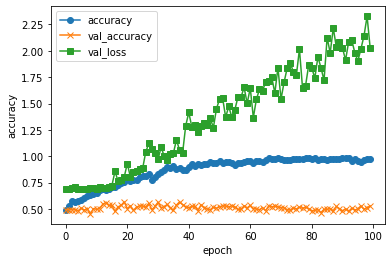

In [10]:
# トレーニング
history = model.fit(x_train_input, y_train, batch_size = 32, epochs = 100, verbose = 1, validation_data = (x_test_input, y_test))

score = model.evaluate(x_test_input, y_test, verbose = 1)
print("Test score", score[0])
print("Test accuracy", score[1])

# Setting Parameters
acc = history.history["accuracy"] # 出力するものは"history"に記載されているものを参照する
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# acc, val_accのプロット
plt.plot(acc, label="accuracy", ls="-", marker="o")
plt.plot(history.history["val_accuracy"], label = "val_accuracy", ls = "-", marker = "x")
plt.plot(history.history["val_loss"], label = "val_loss", ls = "-", marker = "s")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc = "best")

In [11]:
pred = np.argmax(model.predict(x_test_input[0:100]), axis = 1)
print("Prediction")
print(pred)
print("Observed")
print(np.argmax(y_test[0:100], axis=1))

Prediction
[1 0 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 0 1 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 1
 1 0 1 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1
 1 1 0 0 0 1 1 1 0 1 1 1 1 0 1 0 0 1 0 1 0 0 1 1 0 1]
Observed
[0 0 1 1 1 0 0 0 1 1 0 1 0 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 0 1 0 0 1 0 1 1
 1 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 1
 0 1 0 1 1 0 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 0]
